# Introduction
## Amazon food product reviews --Setiment Analysis

This is a very simple logistic regression model that ourputs a binary prediction. It was possible to perform a mltiu-class output. However, the model would perform poorly on the lower three classes (1,2,3) because their review counts were signicantly low in comparison to the higher two classes (4,5). Hence I decided to run a binary classification with 5-star reviews as positive (1), and 4-start and below reviews as negative (0).

The model was able to predict a binary outcome with 82.3% accuracy


In [39]:
#Import what's necessary
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import time
import re

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
rcParams['figure.figsize'] = 12, 8

In [42]:
#Import dataset
df = pd.read_csv('/Users/Mohamad/Python/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Step1: Explore

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [43]:
#Delete unwanted columns
del df['Id']
del df['ProductId']
del df['UserId']
del df['ProfileName']
del df['HelpfulnessNumerator']
del df['HelpfulnessDenominator']
del df['Time']

In [44]:
#Concatenate the two text columns
df['review'] = df['Summary']+df['Text']
del df['Summary']
del df['Text']


In [31]:
df.isna().sum()

Score      0
review    27
dtype: int64

In [45]:
#Remove null values
df.review.fillna("",inplace = True)
df.head()

,Score,review
0,5,Good Quality Dog FoodI have bought several of ...
1,1,Not as AdvertisedProduct arrived labeled as Ju...
2,4,"""Delight"" says it allThis is a confection that..."
3,2,Cough MedicineIf you are looking for the secre...
4,5,Great taffyGreat taffy at a great price. Ther...


In [35]:
#Inspect the scores
print(len(df.Score))
print(df.Score.value_counts())
df.Score.value_counts()/len(df.Score)

568454
5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64


5    0.638789
4    0.141885
1    0.091948
3    0.075010
2    0.052368
Name: Score, dtype: float64

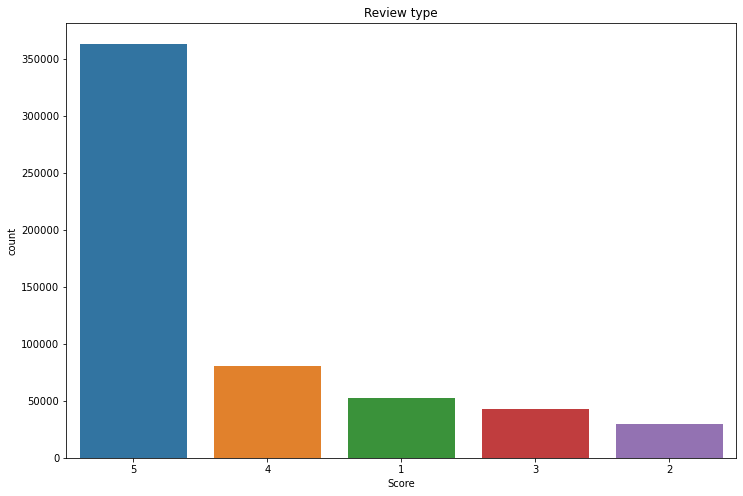

In [46]:
sns.countplot(
  x='Score',
  data=df,
  order=df.Score.value_counts().index
)

plt.title("Review type");

## Step2: Transform

In [58]:
#Transform the reviews into binary since the number of reviews
#isn't equally distributed among classes 
#We will assume 1 for positive and 0 for negative
df["review_type"] = df["Score"].apply(lambda x: 0 if x < 4 else 1)

In [59]:
df.review_type.value_counts()

1    443777
0    124677
Name: review_type, dtype: int64

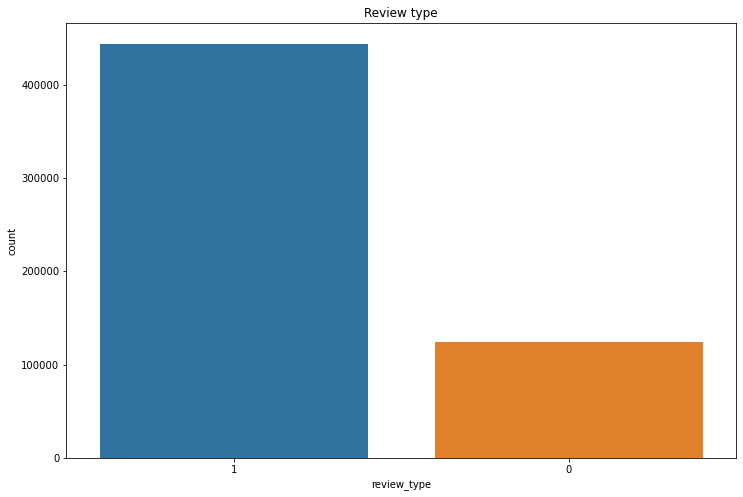

In [60]:
sns.countplot(
  x='review_type',
  data=df,
  order=df.review_type.value_counts().index
)

plt.title("Review type");

In [61]:
#Create seperate dfs
positive_reviews = df[df.review_type == 1]
negative_reviews = df[df.review_type == 0]

In [62]:
print(positive_reviews.shape, negative_reviews.shape)

(443777, 3) (124677, 3)


In [63]:
#Resample reviews to prepare data for better training
positive_df = positive_reviews.sample(n=len(negative_reviews), random_state=RANDOM_SEED)
negative_df = negative_reviews

In [64]:
#Append df
review_df = positive_df.append(negative_df).reset_index(drop=True)
review_df.shape

(249354, 3)

In [65]:
review_df.head()

,Score,review,review_type
0,5,Great Gluten Free PastaWhen I had to give up g...,1
1,4,Great DealThe cans are usually a little banged...,1
2,5,Such good coffee!This is my absolute favorite ...,1
3,5,"Good TeaThis is the place to buy a healthy, go...",1
4,5,Fantastic.This formula is really great. It mix...,1


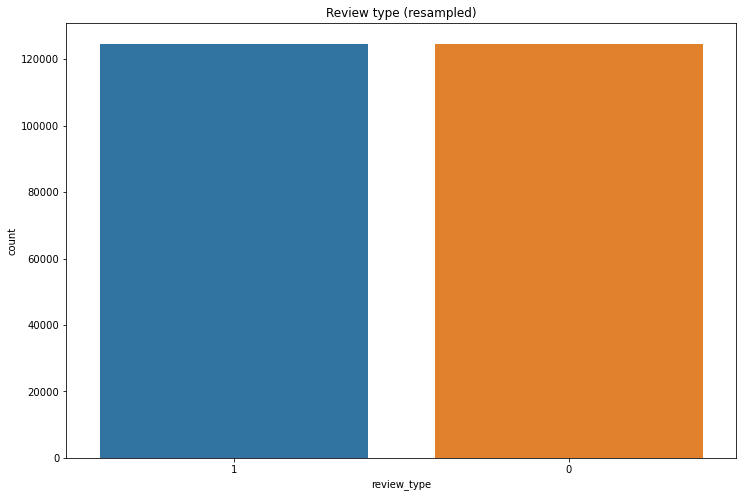

In [66]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.title("Review type (resampled)");

In [67]:
#Stop words and patterns
patterns = r'\b[^\d\W][^\d\W]+\b'

In [68]:
#Modify English stop words list
my_stop_words = ENGLISH_STOP_WORDS.union(['food', 'item', 'product'])

In [69]:
#Instaniate a count vector BOW
vect = CountVectorizer(max_features=1000,
                       max_df=0.6, stop_words=my_stop_words,
                       token_pattern=patterns)

In [105]:
#Create token features df
X = vect.fit_transform(review_df.review)
X = X.toarray()
X = pd.DataFrame(X, columns=vect.get_feature_names())

In [106]:
#Add an extra features
X['len'] = review_df.review.str.len()
#X['score'] = review_df.Score
X.shape

(249354, 1001)

In [107]:
#Create an isolated test set (I tuned reg strength manually)
#Shuffle index then Create features and targets
a = np.arange(0,249354)
np.random.shuffle(a)

features = X.iloc[a[:224418],:]
features_validate = X.iloc[a[224418:],:]

y = review_df.review_type[a[:224418]]
y_validate = review_df.review_type[a[224418:]]

In [108]:
#Save memory!
del X

In [109]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(features,y, test_size=0.2,
                                                    random_state=123,shuffle=True,
                                                    stratify=y)

## Step3: Build the model

In [130]:
#Instantiate a logistic regression moel
log_reg = LogisticRegression(C= 0.001)

In [131]:
#Fit & predict the model (I'm recording time here)
import warnings; warnings.simplefilter('ignore')
start_time = time.time()
log_reg.fit(X_train,y_train)
end_time = time.time();

In [132]:
print((end_time-start_time)/60)

0.6791343688964844


In [133]:
preds = log_reg.predict(X_test)

In [134]:
#Print out scores
print('Accuracy on test data: ', log_reg.score(X_test,y_test))
print('Accuracy on training data: ', log_reg.score(X_train,y_train))

Accuracy on test data:  0.8262855360484805
Accuracy on training data:  0.8262279011217931


In [135]:
#Print out accuracy and cofusion matrix
print(accuracy_score(y_test,preds))
print(confusion_matrix(y_test,preds))

0.8262855360484805
[[18816  3632]
 [ 4165 18271]]


In [136]:
#Now let's predict on unseen data
preds_unseen = log_reg.predict(features_validate)

In [137]:
#Print out accuracy and cofusion matrix
print(accuracy_score(y_validate,preds_unseen))
print(confusion_matrix(y_validate,preds_unseen))

0.8232675649663138
[[10386  2053]
 [ 2354 10143]]
